# GETTING 3 SEPARATE DF'S TO LATER COMBINE INTO 1



Overview Steps of Following Work:

1. Top 5 Short Haul Dataset: df_top5short_final
2. Top 5 Medium Haul Dataset: df_top5med_final
3. Top 5 Long Haul Dataset: df_top5long_final
4. Combined Total Dataset: df_all_final
5. Add Columns defining Short, Med, Long Haul
6. Add Pandemic features
7. Add Holiday features
8. Add Weekday/Weekend features
9. Test Colinearity
10. [IMPORTANT] Code needed to copy to be able to get the right dataset

In [2]:
#Import Packages
import snowflake.connector
import pandas as pd

# 1. Code Needed to Copy to Get the Right Dataset

### Short Haul DF

In [3]:
# DATA GRAIN:
#expedia
#date: April 2021-March 2022
#fare_type: Economy and ECONOMY
#departure_stops =1
#duration_hrsint <=3
#Top 3 CXR: AA, UA, DW
#TOP 5 SHORT FLIGHTS
# 0	DFWORD	1644927
# 1	ORDDFW	1638829
# 2	ORDIAH	1154915
# 3	IAHORD	1125903
# 4	DFWATL	1091099
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT <=3 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT <= 3 ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE 
        (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
        AND  (MARKET = 'DFWORD' 
            OR MARKET = 'ORDDFW' 
            OR MARKET = 'ORDIAH' 
            OR MARKET = 'IAHORD' 
            OR MARKET = 'DFWATL')
    ;
    
 
    """)

    df_top5short_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [4]:
df_top5short_final = df_top5short_final.dropna()

### Med Haul DF

In [5]:
#Splitting the departure_date into new columns of year/month
    
# 0	ATLDEN	832415
# 1	DFWLAS	500648
# 2	EWRIAH	366561
# 3	IAHEWR	348468
# 4	LAXHNL	332463
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 (DURATION_HRS_FLT >= 3 AND DURATION_HRS_FLT <=6)
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE (DURATION_HRSINT >= 3 AND DURATION_HRSINT <=6) ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE 
        (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
        AND  (MARKET = 'ATLDEN' 
            OR MARKET = 'DFWLAS' 
            OR MARKET = 'EWRIAH' 
            OR MARKET = 'IAHEWR' 
            OR MARKET = 'LAXHNL')
 
      ;
 
    """)

    df_top5med_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [6]:
df_top5med_final = df_top5med_final.dropna()

### Long Haul DF

In [7]:
#Splitting the departure_date into new columns of year/month
# 0	EZEMIA	25349
# 1	JFKSFO	25128
# 2	MIAEZE	23597
# 3	LHRJFK	14548
# 4	MIAGRU	14450

try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
         WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT >=5 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT >6 ORDER BY DURATION_HRSINT DESC
        )
        
        SELECT * FROM df3
         WHERE 
         (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
            AND  (MARKET = 'EZEMIA' 
             OR MARKET = 'JFKSFO' 
             OR MARKET = 'MIAEZE' 
             OR MARKET = 'LHRJFK' 
             OR MARKET = 'MIAGRU')

     
      ;
 
    """)

    df_top5long_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [8]:
df_top5long_final = df_top5long_final.dropna()

### Combining all 3 dataset

In [9]:
#Combining short, med, long haul dfs together
short_med = pd.concat([df_top5short_final, df_top5med_final], axis=0)
df_all = pd.concat([short_med, df_top5long_final], axis=0)

### Adding Column HAUL_TYPE

In [10]:
df_all['HAUL_TYPE'] = df_all['DURATION_HRSINT'].apply(lambda x: 'short'if x <= 3 else ('medium' if (x >3 and x <=6) else 'long'))


In [30]:
df_all

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,FLIGHT_NUMBER,DEPARTURE_TIME,ROUTE,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT,HAUL_TYPE
0,ORDDFW,EXP,UA,2022-02-02 00:20:00,7337,2022-02-26,7361,0,ECONOMY,118.60,6087,15:35,15:35 - ORD :: 18:31 - DFW,ORDDFW20222,2:56,2,2022,3.0,short
1,ORDDFW,EXP,AA,2022-02-02 00:20:00,7337,2022-02-10,7345,0,ECONOMY,148.60,2754,07:00,07:00 - ORD :: 09:37 - DFW,ORDDFW20222,2:37,2,2022,3.0,short
2,ORDDFW,EXP,AA,2022-02-02 00:20:00,7337,2022-02-10,7345,0,ECONOMY,220.60,1106,11:25,11:25 - ORD :: 14:00 - DFW,ORDDFW20222,2:35,2,2022,3.0,short
3,ORDDFW,EXP,UA,2022-02-02 00:20:00,7337,2022-02-10,7345,0,ECONOMY,227.60,6309,19:35,19:35 - ORD :: 22:30 - DFW,ORDDFW20222,2:55,2,2022,3.0,short
4,ORDIAH,EXP,UA,2022-02-02 00:20:00,7337,2022-02-13,7348,0,ECONOMY,88.60,2675,06:00,06:00 - ORD :: 08:55 - IAH,ORDIAH20222,2:55,2,2022,3.0,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898,JFKSFO,EXP,DL,2021-10-31 09:28:00,7243,2021-11-21,7264,0,ECONOMY,258.39,343,09:05,09:05 - JFK :: 12:44 - SFO,JFKSFO202111,6:39,10,2021,7.0,long
2899,JFKSFO,EXP,DL,2021-10-31 09:28:00,7243,2021-11-21,7264,0,ECONOMY,258.39,442,11:05,11:05 - JFK :: 14:39 - SFO,JFKSFO202111,6:34,10,2021,7.0,long
2900,JFKSFO,EXP,UA,2021-10-31 09:28:00,7243,2021-11-21,7264,0,ECONOMY,268.40,523,16:55,16:55 - JFK :: 20:41 - SFO,JFKSFO202111,6:46,10,2021,7.0,long
2901,JFKSFO,EXP,AA,2021-10-31 09:28:00,7243,2021-11-21,7264,0,ECONOMY,283.40,9354,19:15,19:15 - JFK :: 23:00 - SFO,JFKSFO202111,6:45,10,2021,7.0,long


# 7. cleaning data

In [11]:
a = df_all

In [29]:
b = df_all

In [30]:
import time
import datetime as dt

# transforming type of DATE and QTS
a['tDATE'] = pd.to_datetime(a['DEPARTURE_DATE'])
a['tqts'] = pd.to_datetime(a['QTS'])
# calculating time till Departure
a['re'] = a['tDATE'] - a['tqts']
a

KeyboardInterrupt: 

In [31]:
import time
import datetime as dt

# transforming type of DATE and QTS
b['tDATE'] = pd.to_datetime(b['DEPARTURE_DATE'])
b['tqts'] = pd.to_datetime(b['QTS'])
# calculating time till Departure
b['re'] = b['tDATE'] - b['tqts']
b

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,...,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT,HAUL_TYPE,tDATE,tqts,re,DaysTillDeparture
0,IAHORD,EXP,UA,2022-02-17 15:09:00,7352,2022-03-15,7378,0,economy,103.60,...,IAHORD20223,2:44:00,2,2022,3.0,short,2022-03-15,2022-02-17 15:09:00,25 days 08:51:00,1month
1,ORDIAH,EXP,UA,2022-02-16 03:25:00,7351,2022-03-12,7375,0,economy,103.60,...,ORDIAH20223,2:50:00,2,2022,3.0,short,2022-03-12,2022-02-16 03:25:00,23 days 20:35:00,1month
2,ORDIAH,EXP,UA,2022-02-16 03:25:00,7351,2022-03-06,7369,0,economy,118.60,...,ORDIAH20223,2:57:00,2,2022,3.0,short,2022-03-06,2022-02-16 03:25:00,17 days 20:35:00,1month
3,ORDIAH,EXP,AA,2022-02-16 03:25:00,7351,2022-03-06,7369,0,economy,138.60,...,ORDIAH20223,2:53:00,2,2022,3.0,short,2022-03-06,2022-02-16 03:25:00,17 days 20:35:00,1month
4,ORDIAH,EXP,UA,2022-02-16 03:25:00,7351,2022-03-06,7369,0,economy,172.60,...,ORDIAH20223,2:50:00,2,2022,3.0,short,2022-03-06,2022-02-16 03:25:00,17 days 20:35:00,1month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,JFKSFO,EXP,DL,2021-08-03 09:17:00,7154,2021-10-28,7240,0,economy,198.40,...,JFKSFO202110,6:49:00,8,2021,7.0,long,2021-10-28,2021-08-03 09:17:00,85 days 14:43:00,2-4month
2764,JFKSFO,EXP,DL,2021-08-03 09:17:00,7154,2021-10-28,7240,0,economy,238.67,...,JFKSFO202110,7:4:00,8,2021,7.0,long,2021-10-28,2021-08-03 09:17:00,85 days 14:43:00,2-4month
2765,JFKSFO,EXP,DL,2021-08-03 09:17:00,7154,2021-10-21,7233,0,economy,198.40,...,JFKSFO202110,6:44:00,8,2021,7.0,long,2021-10-21,2021-08-03 09:17:00,78 days 14:43:00,2-4month
2766,JFKSFO,EXP,DL,2021-08-03 09:17:00,7154,2021-10-21,7233,0,economy,238.67,...,JFKSFO202110,7:4:00,8,2021,7.0,long,2021-10-21,2021-08-03 09:17:00,78 days 14:43:00,2-4month


In [14]:
# calculate days till departure
a['DaysTillDeparture'] = a['re'].dt.components.days

In [32]:
# calculate days till departure
b['DaysTillDeparture'] = b['re'].dt.components.days

In [51]:
a

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,...,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT,HAUL_TYPE,tDATE,tqts,re,DaysTillDeparture
0,DFWORD,EXP,UA,2022-02-17 19:10:00,7352,2022-03-09,7372,0,ECONOMY,162.6,...,DFWORD20223,2:32,2,2022,3.0,short,2022-03-09,2022-02-17 19:10:00,19 days 04:50:00,19
1,ORDIAH,EXP,UA,2022-02-17 19:10:00,7352,2022-03-06,7369,0,ECONOMY,138.6,...,ORDIAH20223,2:50,2,2022,3.0,short,2022-03-06,2022-02-17 19:10:00,16 days 04:50:00,16
2,ORDDFW,EXP,AA,2022-02-17 19:10:00,7352,2022-03-13,7376,0,ECONOMY,162.6,...,ORDDFW20223,2:30,2,2022,3.0,short,2022-03-13,2022-02-17 19:10:00,23 days 04:50:00,23
3,ORDDFW,EXP,UA,2022-02-17 19:10:00,7352,2022-03-13,7376,0,ECONOMY,162.6,...,ORDDFW20223,2:41,2,2022,3.0,short,2022-03-13,2022-02-17 19:10:00,23 days 04:50:00,23
4,ORDDFW,EXP,AA,2022-02-17 19:10:00,7352,2022-03-13,7376,0,ECONOMY,194.6,...,ORDDFW20223,2:30,2,2022,3.0,short,2022-03-13,2022-02-17 19:10:00,23 days 04:50:00,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,JFKSFO,EXP,DL,2022-01-19 05:18:00,7323,2022-04-04,7398,0,ECONOMY,188.6,...,JFKSFO20224,6:44,1,2022,7.0,long,2022-04-04,2022-01-19 05:18:00,74 days 18:42:00,74
2595,JFKSFO,EXP,DL,2022-01-19 05:18:00,7323,2022-04-04,7398,0,ECONOMY,318.6,...,JFKSFO20224,6:43,1,2022,7.0,long,2022-04-04,2022-01-19 05:18:00,74 days 18:42:00,74
2596,JFKSFO,EXP,DL,2022-01-19 05:18:00,7323,2022-04-25,7419,0,ECONOMY,161.6,...,JFKSFO20224,6:44,1,2022,7.0,long,2022-04-25,2022-01-19 05:18:00,95 days 18:42:00,95
2597,JFKSFO,EXP,AA,2022-01-20 02:46:00,7324,2022-01-22,7326,0,ECONOMY,238.6,...,JFKSFO20221,6:53,1,2022,7.0,long,2022-01-22,2022-01-20 02:46:00,1 days 21:14:00,1


In [15]:
#fixing all of the -1 values for the DaysTillDeparture
a.loc[(a["DaysTillDeparture"] == -1), "DaysTillDeparture" ] = 0

In [33]:
#fixing all of the -1 values for the DaysTillDeparture
b.loc[(b["DaysTillDeparture"] == -1), "DaysTillDeparture" ] = 0

In [16]:
pd.options.display.max_rows = 4000

In [17]:
#see the distribution of daystilldeparture values
dtd_distr = a['DaysTillDeparture'].value_counts()
df_dtd_distr = pd.DataFrame(dtd_distr)
df_dtd_distr.index.name = 'numdays_beforedep'

print(df_dtd_distr.sort_values('numdays_beforedep'))

                   DaysTillDeparture
numdays_beforedep                   
0                             534841
1                             376121
2                             345462
3                             342214
4                             343857
5                             340367
6                             339669
7                             332917
8                             333117
9                             336875
10                            334859
11                            335783
12                            338967
13                            347773
14                            340386
15                            339648
16                            341433
17                            342365
18                            341338
19                            340102
20                            338590
21                            331223
22                            329730
23                            330709
24                            330732
2

In [18]:
a['DaysTillDeparture'] = a['DaysTillDeparture'].apply(lambda x: '1month'if x <= 30 else ('2-4month' if (x > 30 and x <=119) else '4+month'))


In [19]:
a.loc[a['DaysTillDeparture'] == "4+month"]

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,...,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT,HAUL_TYPE,tDATE,tqts,re,DaysTillDeparture
17595,ORDDFW,EXP,UA,2022-04-14 09:34:00,7408,2022-10-11,7588,0,ECONOMY,205.6,...,ORDDFW202210,2:35,4,2022,3.0,short,2022-10-11,2022-04-14 09:34:00,179 days 14:26:00,4+month
21536,DFWORD,EXP,UA,2021-04-14 05:42:00,7043,2021-08-19,7170,0,ECONOMY,143.4,...,DFWORD20218,2:31,4,2021,3.0,short,2021-08-19,2021-04-14 05:42:00,126 days 18:18:00,4+month
21545,IAHORD,EXP,UA,2021-04-21 05:50:00,7050,2021-08-21,7172,0,ECONOMY,157.4,...,IAHORD20218,2:40,4,2021,3.0,short,2021-08-21,2021-04-21 05:50:00,121 days 18:10:00,4+month
21546,IAHORD,EXP,UA,2021-04-21 05:50:00,7050,2021-08-21,7172,0,ECONOMY,157.4,...,IAHORD20218,2:33,4,2021,3.0,short,2021-08-21,2021-04-21 05:50:00,121 days 18:10:00,4+month
21547,IAHORD,EXP,UA,2021-04-21 05:50:00,7050,2021-08-21,7172,0,ECONOMY,157.4,...,IAHORD20218,2:44,4,2021,3.0,short,2021-08-21,2021-04-21 05:50:00,121 days 18:10:00,4+month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,JFKSFO,EXP,DL,2021-08-04 08:10:00,7155,2021-12-16,7289,0,ECONOMY,408.4,...,JFKSFO202112,6:49,8,2021,7.0,long,2021-12-16,2021-08-04 08:10:00,133 days 15:50:00,4+month
2610,JFKSFO,EXP,AA,2021-10-12 18:09:00,7224,2022-02-10,7345,0,ECONOMY,98.4,...,JFKSFO20222,6:41,10,2021,7.0,long,2022-02-10,2021-10-12 18:09:00,120 days 05:51:00,4+month
2611,JFKSFO,EXP,AA,2021-10-12 18:09:00,7224,2022-02-10,7345,0,ECONOMY,98.4,...,JFKSFO20222,6:45,10,2021,7.0,long,2022-02-10,2021-10-12 18:09:00,120 days 05:51:00,4+month
2612,JFKSFO,EXP,AA,2021-10-12 18:09:00,7224,2022-02-10,7345,0,ECONOMY,118.4,...,JFKSFO20222,6:34,10,2021,7.0,long,2022-02-10,2021-10-12 18:09:00,120 days 05:51:00,4+month


### Cleaning other variables

In [20]:
# cast all string entry in FARE_TYPE column to lower case
a['FARE_TYPE'] = a['FARE_TYPE'].apply(lambda x: str.lower(x))

In [21]:
# clean the data/type of DURATION

# first convert to string
def convert_to_string (x):
    string = str(x).split('\n')[0].split(' ')[-1] + ':00'
    return string
a['DURATION_FLIGHT'] = a['DURATION_FLIGHT'].apply(convert_to_string)
a['DURATION_FLIGHT']

0       2:44:00
1       2:50:00
2       2:57:00
3       2:53:00
4       2:50:00
         ...   
2763    6:49:00
2764     7:4:00
2765    6:44:00
2766     7:4:00
2767    6:31:00
Name: DURATION_FLIGHT, Length: 10909463, dtype: object

In [76]:
c = b.dropna()

In [22]:
a = a.dropna()

In [46]:
df_all = df_all.dropna()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

# visual_overview = c 
# #Count of flights v/s pandemic
# plt.figure(figsize = (15, 10))
# plt.title('Count of flights with  Pandemic time')
# colors = sns.color_palette('bright')[0:5]
# plt.pie(x= 'Pandemic', data =visual_overview)

In [94]:
d = c.query('HAUL_TYPE == "short"&DaysTillDeparture =="1month" ')

In [96]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api

In [97]:
arima = d[['QTS', "FARE"]]
arima.set_index('QTS')
arima= arima.groupby(['QTS']).mean()
arima

,FARE
QTS,
2020-11-09 18:36:00,135.100000
2020-11-09 18:38:00,210.957143
2020-11-09 18:39:00,270.242857
2020-11-09 18:40:00,233.100000
2020-11-09 18:41:00,208.100000
...,...
2022-04-20 23:10:00,308.901905
2022-04-21 00:20:00,260.731764
2022-04-21 00:21:00,270.012368


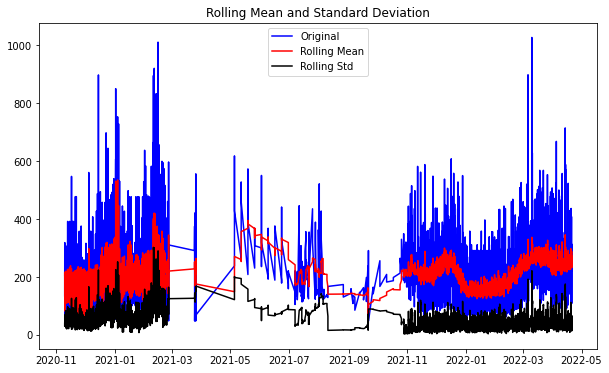

Results of dickey fuller test
Test Statistics               -7.851638e+00
p-value                        5.580888e-12
No. of lags used               4.500000e+01
Number of observations used    1.848700e+04
critical value (1%)           -3.430704e+00
critical value (5%)           -2.861696e+00
critical value (10%)          -2.566853e+00
dtype: float64


In [98]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = statsmodels.tsa.stattools.adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(arima)

In [102]:
arima['FARE']

QTS
2020-11-09 18:36:00    135.100000
2020-11-09 18:38:00    210.957143
2020-11-09 18:39:00    270.242857
2020-11-09 18:40:00    233.100000
2020-11-09 18:41:00    208.100000
                          ...    
2022-04-20 23:10:00    308.901905
2022-04-21 00:20:00    260.731764
2022-04-21 00:21:00    270.012368
2022-04-21 01:18:00    260.425211
2022-04-21 01:19:00    272.412010
Name: FARE, Length: 18533, dtype: float64

<Figure size 720x432 with 0 Axes>

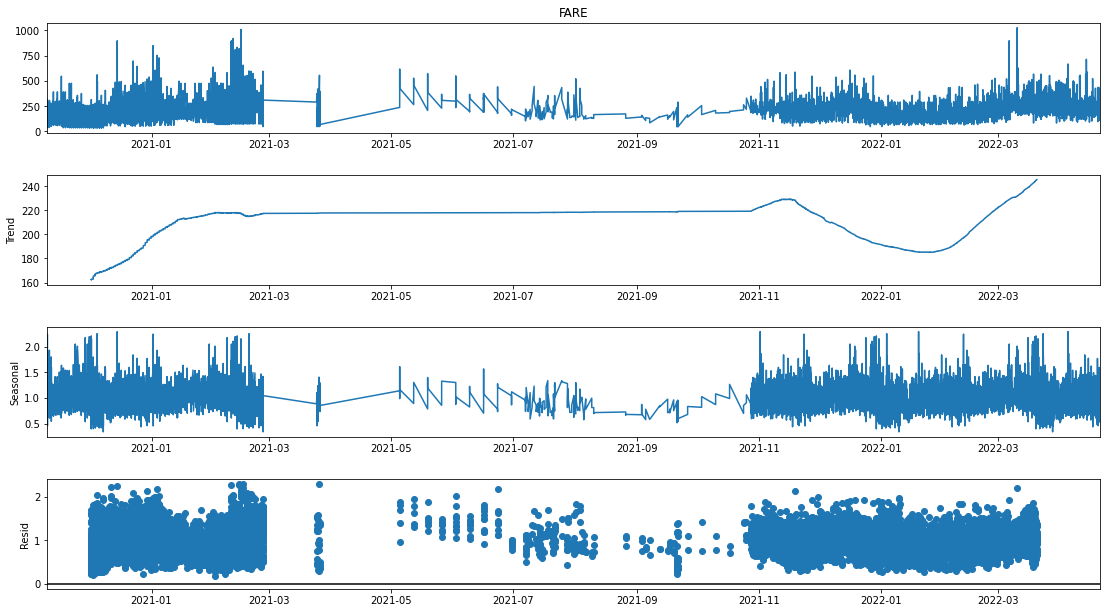

In [103]:
# p = 0.00003429016

#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
res = seasonal_decompose(arima['FARE'], model='multiplicative', period=int(len(arima)/4))
fig = plt.figure()  
fig = res.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


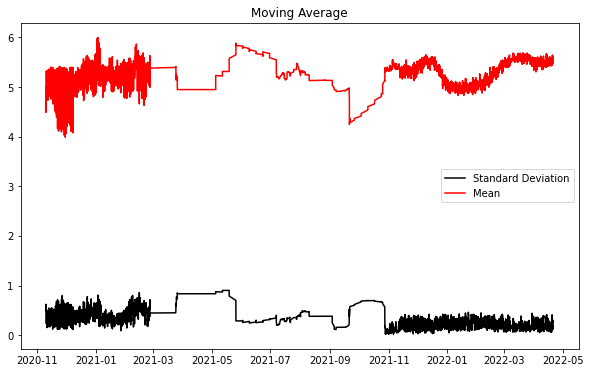

In [105]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(arima)
moving_avg = df_log.rolling(20).mean()
std_dev = df_log.rolling(20).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

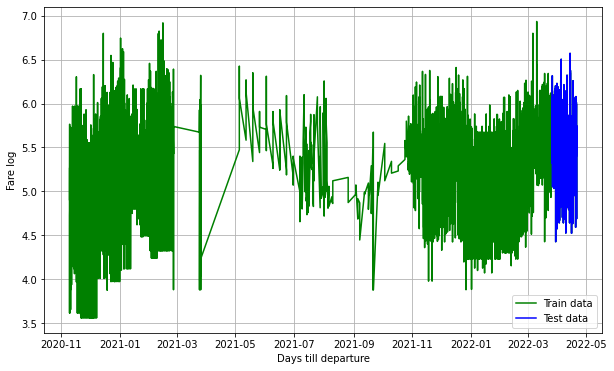

In [106]:

#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Days till departure')
plt.ylabel('Fare log')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=102456.396, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.79 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=81813.788, Time=0.73 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12337.370, Time=0.86 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=12162.492, Time=1.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12103.360, Time=4.97 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=12160.529, Time=1.61 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=4.57 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12024.763, Time=16.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11971.274, Time=11.95 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12002.248, Time=10.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=13219.833, Time=1.13 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : A

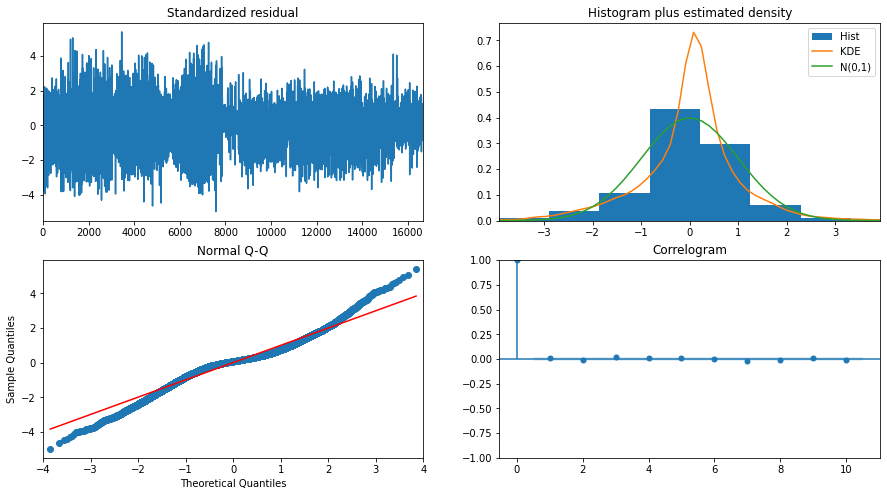

In [118]:

model_autoARIMA = auto_arima(train_data.FARE, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [119]:
model = statsmodels.tsa.arima.model.ARIMA(train_data.FARE, order=(1,0,3))
results_ARIMA = model.fit()  
print(results_ARIMA.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   FARE   No. Observations:                16676
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -5956.354
Date:                Wed, 20 Apr 2022   AIC                          11924.709
Time:                        23:40:47   BIC                          11971.039
Sample:                             0   HQIC                         11940.001
                              - 16676                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2038      0.020    258.654      0.000       5.164       5.243
ar.L1          0.9666      0.002    400.875      0.000       0.962       0.971
ma.L1         -0.6804      0.006   -112.318      0.0

In [120]:
import statsmodels
results_ARIMA.plot_predict(dynamic = False)
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

In [123]:

fc, se, conf = results_ARIMA.forecast(alpha=0.05) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: not enough values to unpack (expected 3, got 1)

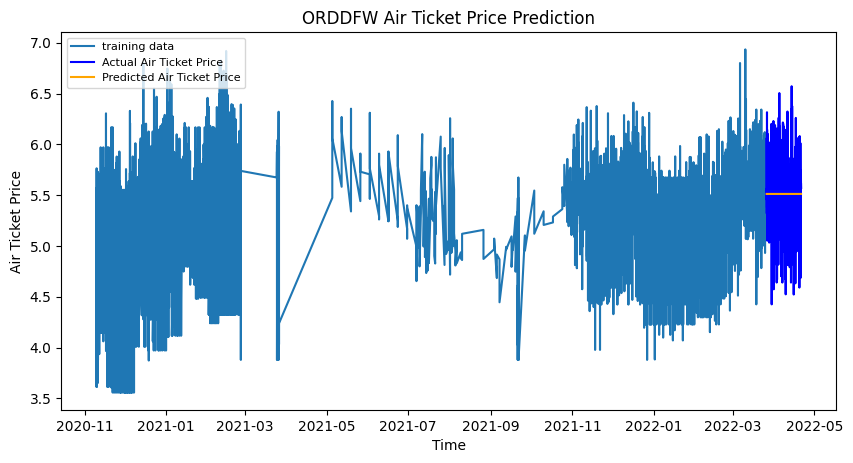

In [124]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Air Ticket Price')
plt.plot(fc_series, color = 'orange',label='Predicted Air Ticket Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
plt.title('ORDDFW Air Ticket Price Prediction')
plt.xlabel('Time')
plt.ylabel('Air Ticket Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()